Importing libraries

In [1]:
#introducing libraries
!pip install numpy scipy pandas>1.0 matplotlib lmfit colour
#calling up libraries
from datetime import datetime
import pandas as pd
import numpy as np
import scipy
from scipy import optimize
import scipy.integrate as integrate
from scipy.integrate import quad
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from mpl_toolkits import mplot3d
from datetime import timedelta
from lmfit.models import LorentzianModel
import statistics
from matplotlib.collections import LineCollection 
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from scipy.signal import argrelmax
#import CSV data from drive
from google.colab import drive
import glob
import os
drive.mount('drive', force_remount=True)
folder = "/content/drive/MyDrive/PBDBT:ITIC Cells/Pre-processed data"
all_files = glob.glob(os.path.join(folder, '*.csv'))
Spec_data = {}
Sorb_data = {}
Irr_data = {}
titles = []



for filename in all_files:
  #Simplify name
  new_name = filename.replace(".csv", "").replace("/content/drive/MyDrive/PBDBT:ITIC Cells/Pre-processed data/","")
  #import data
  df = pd.read_csv(filename, sep=',', header=0)

  #Some cleaning
  df.drop(df.tail(14).index, inplace=True)
  df = df.rename({'0.00000E+0.1':'0.000000000'}, axis=1)
  cols = df.columns.values
  cols[0] = 'Wavelength(nm)'
  df.columns = cols
  df = df.set_index('Wavelength(nm)')
  #remove rows (wavelengths) with at least 3 na values
  df = df.dropna(axis=0, thresh=3)

  #change strings to numbers
  df = df.astype(float)
  df['Energy(eV)'] = 1239.842/df.index.astype(float)
  df = df.set_index('Energy(eV)')
  df.columns = np.around(pd.to_numeric(df.columns), 2)

  titles.append(new_name)
  Spec_data[new_name] = df

Spec_data



Mounted at drive


{'01 CB blend 1mW magic angle -5--4000ps -bg -t0':             -4.83     -4.58         -4.33     ...   2692.70   3281.96   4000.18
 Energy(eV)                                    ...                              
 1.522203    0.000090 -0.000008  3.228720e-05  ...  0.000294  0.000250  0.000325
 1.515835   -0.000067 -0.000091  3.480710e-05  ...  0.000158  0.000241  0.000183
 1.509519   -0.000088 -0.000113  7.494070e-05  ...  0.000182  0.000248  0.000269
 1.503254   -0.000044 -0.000054  8.701310e-05  ...  0.000194  0.000208  0.000261
 1.497041   -0.000096 -0.000021  4.343670e-05  ...  0.000226  0.000228  0.000236
 ...              ...       ...           ...  ...       ...       ...       ...
 0.925815    0.000011 -0.000021  3.686230e-05  ... -0.000002  0.000245  0.000297
 0.923408    0.000011 -0.000083  1.020540e-04  ...  0.000214  0.000234  0.000281
 0.921021    0.000072 -0.000019  6.041390e-05  ...  0.000271  0.000209  0.000274
 0.918646    0.000052 -0.000032 -5.020700e-07  ...  0.00020

Importing data from google drive folder, sorting each into absorbance, spectroscope runs, and general spectroscope data.

In [2]:
for name in Spec_data:
  if 'UvVis' in name:
    new = Spec_data[name][~((Spec_data[name].index <= 1239.842/400) & (Spec_data[name].index >= 1239.842/700))]
    print(Spec_data[name].loc[new.index, :])
    Spec_data[name].loc[new.index, :] = np.nan
    Spec_data[name] = Spec_data[name]/0.6

  else:
    print(name)
    new = Spec_data[name][~((Spec_data[name].index > 1239.842/1400) & (Spec_data[name].index < 1239.842/850))]
    print(Spec_data[name].loc[new.index, :])
    Spec_data[name].loc[new.index, :] = np.nan
    Spec_data[name] = Spec_data[name]*3

#remember to remove laser signal
for name in Spec_data:
  if 'UvVis' in name:
    new = Spec_data[name][((Spec_data[name].index >= 1239.842/540) & (Spec_data[name].index <= 1239.842/500))]
    print(Spec_data[name].loc[new.index, :])
    Spec_data[name].loc[new.index, :] = np.nan
merged_data = {}
for name1 in Spec_data:
  for name2 in Spec_data:
    if (name1 != name2) & (name1[0:2] == name2[0:2]):
      comb = pd.concat([Spec_data[name1], Spec_data[name2]])
      if 'UvVis' not in name1:
        new_name = name1[0:12]
      elif 'UvVis' not in name2:
        new_name = name2[0:12]
      merged_data[new_name] = comb.sort_index()

merge_interp = {}
for name in merged_data:
  merge_interp[name] = (merged_data[name].T).interpolate().T

merge_interp

Spec_data

            -5.08     -4.83     -4.58     ...   5680.10   6522.54       7489.92
Energy(eV)                                ...                                  
3.413446         NaN       NaN -0.000006  ... -0.000197 -0.000012 -4.678590e-05
3.408060         NaN       NaN  0.000047  ... -0.000043 -0.000094 -3.580060e-05
3.402682         NaN       NaN -0.000060  ... -0.000088 -0.000032 -4.240380e-05
3.397330         NaN       NaN  0.000005  ... -0.000077 -0.000112  5.822000e-06
3.391986         NaN       NaN  0.000055  ... -0.000065  0.000041  2.316390e-05
...              ...       ...       ...  ...       ...       ...           ...
3.121605         NaN       NaN -0.000004  ... -0.000022 -0.000023 -7.571330e-08
3.117084         NaN       NaN -0.000009  ... -0.000035 -0.000022 -2.567270e-05
3.112569         NaN       NaN -0.000003  ... -0.000026 -0.000004 -1.125480e-05
3.108067         NaN       NaN -0.000008  ... -0.000030 -0.000015  8.165110e-06
3.103578         NaN       NaN -0.000005

{'01 CB blend 1mW magic angle -5--4000ps -bg -t0':             -4.83     -4.58     -4.33     ...   2692.70   3281.96   4000.18
 Energy(eV)                                ...                              
 1.522203         NaN       NaN       NaN  ...       NaN       NaN       NaN
 1.515835         NaN       NaN       NaN  ...       NaN       NaN       NaN
 1.509519         NaN       NaN       NaN  ...       NaN       NaN       NaN
 1.503254         NaN       NaN       NaN  ...       NaN       NaN       NaN
 1.497041         NaN       NaN       NaN  ...       NaN       NaN       NaN
 ...              ...       ...       ...  ...       ...       ...       ...
 0.925815    0.000032 -0.000062  0.000111  ... -0.000005  0.000735  0.000892
 0.923408    0.000033 -0.000250  0.000306  ...  0.000642  0.000703  0.000843
 0.921021    0.000217 -0.000058  0.000181  ...  0.000812  0.000626  0.000822
 0.918646    0.000156 -0.000095 -0.000002  ...  0.000609  0.000455  0.001394
 0.916277    0.000119 -0.0

[0.012254880000000001, 0.014978370000000001, 0.01044363, 0.010717019999999999]
[-0.016471, -0.026309666666666665, -0.00418955, -0.012317400000000001]


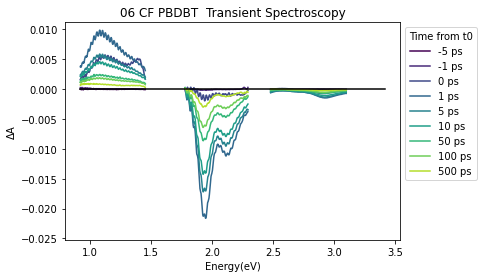

06 CF PBDBT 


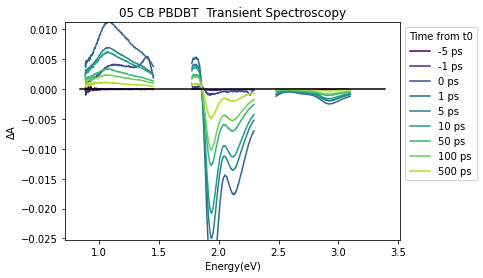

05 CB PBDBT 


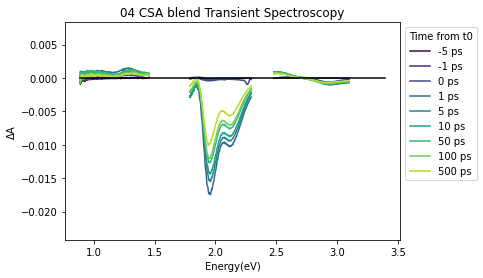

04 CSA blend


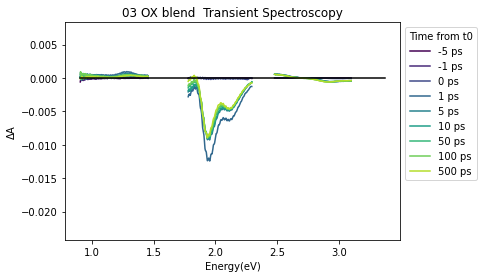

03 OX blend 


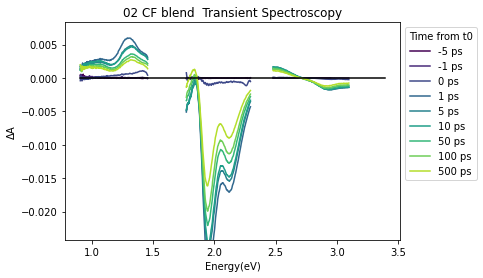

02 CF blend 


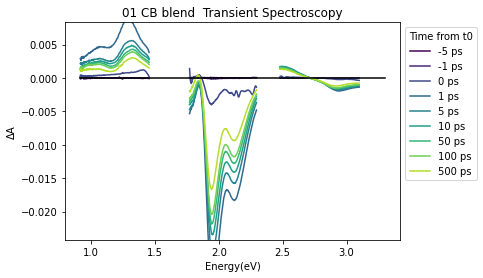

01 CB blend 


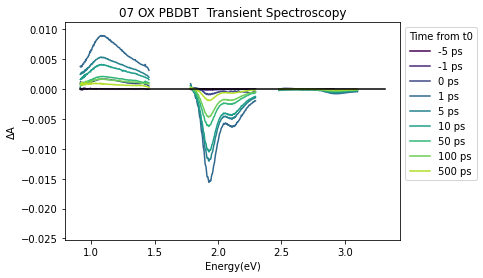

07 OX PBDBT 


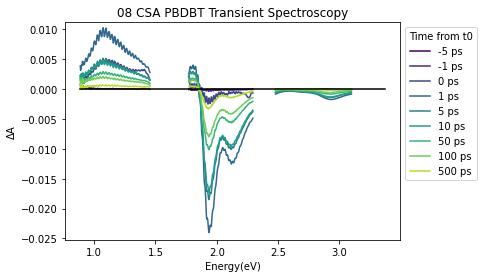

08 CSA PBDBT


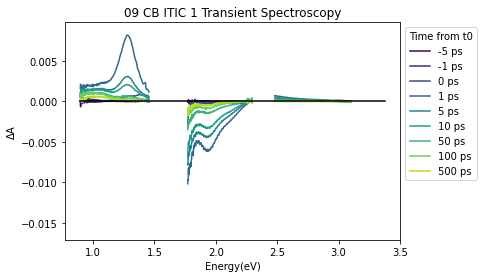

09 CB ITIC 1


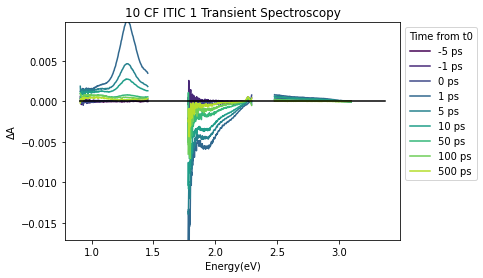

10 CF ITIC 1


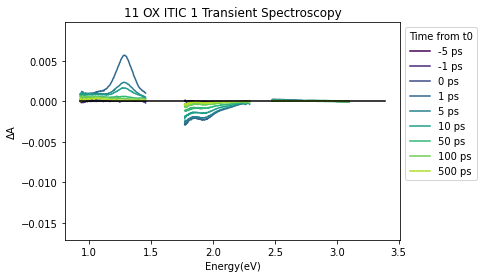

11 OX ITIC 1


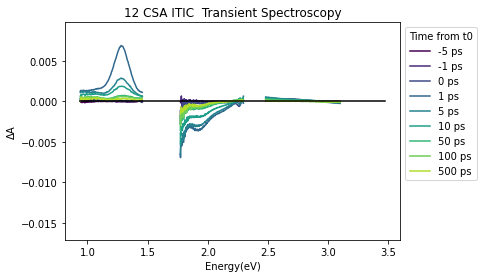

12 CSA ITIC 


In [14]:
def spec_time_data(name, times):
  plt.subplots()
  for i in range(len(times)):
      plt.plot(np.asarray(merge_interp[name].index), np.asarray(merge_interp[name][times[i]]),  label=str(dex[i])+' ps', color=colormap(i/n))
      plt.legend(title='Time from t0', bbox_to_anchor=(1,1), loc="upper left")
      plt.title(name + " Transient Spectroscopy")
      plt.xlabel('Energy(eV)')
      plt.ylabel('ΔA')
      plt.ylim(.65*switch(name, bmin, pmin, imin), 0.65*switch(name, bmax, pmax, imax))
#color method from stack exchange :https://stackoverflow.com/questions/25668828/how-to-create-colour-gradient-in-python
def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)
c1='white' 
c2='black' 
n=len(times)
#better color method?
colormap = cm.get_cmap('viridis')
#find global maxes to fix TA scale
maxes=[]
mins=[]
bmaxes=[]
bmins=[]
pmaxes = []
pmins = []
imaxes=[]
imins=[]
for name in merge_interp:
  if int(name[0:2]) <= 4:
    bmaxes.append(merge_interp[name].max().max())
    bmins.append(merge_interp[name].min().min())
  elif int(name[0:2]) > 4 and int(name[0:2]) <= 8:
    pmaxes.append(merge_interp[name].max().max())
    pmins.append(merge_interp[name].min().min())
  elif int(name[0:2]) > 8:
    imaxes.append(merge_interp[name].max().max())
    imins.append(merge_interp[name].min().min())
  maxes.append(merge_interp[name].max().max())
  mins.append(merge_interp[name].min().min())
bmax = max(bmaxes)
bmin = min(bmins)
pmax = max(pmaxes)
pmin = min(pmins)
imax = max(imaxes)
imin = min(imins)  
gmax = max(maxes)
gmin = min(mins)
print(imaxes)
print(imins)
#routine for switching between type comparisons
def switch(name, a, b, c):
  if int(name[0:2]) <= 4:
    return a
  elif int(name[0:2]) > 4 and int(name[0:2]) <= 8:
    return b
  elif int(name[0:2]) > 8:
    return c
#https://codereview.stackexchange.com/questions/189319/nearest-neighbor-algorithm-general-neares
def find_nearest(array, number, direction): 
    if direction is None:
        idx = (np.abs(array - number)).min()
    elif direction == 'backward':
        _delta = number - array
        _delta_positive = _delta[_delta > 0]
        if not _delta_positive.empty:
            idx = _delta_positive.min()
    elif direction == 'forward':
        _delta = array - number
        _delta_positive = _delta[_delta >= 0]
        if not _delta_positive.empty:
            idx = _delta_positive.min()
    return idx
for name in merge_interp:
  dex = [-5, -1, 0, 1, 5, 10, 50, 100, 500]
  times = []
  for i in range(len(dex)):
    times.append(np.around(find_nearest(merge_interp[name].columns,dex[i], 'forward')+dex[i], 2))
  spec_time_data(name, times)
  plt.plot(np.array(merge_interp[name].index), np.zeros(len(merge_interp[name].index), dtype=float, order='C'), color='black')
  plt.show()


  print(name)
  plt.show()




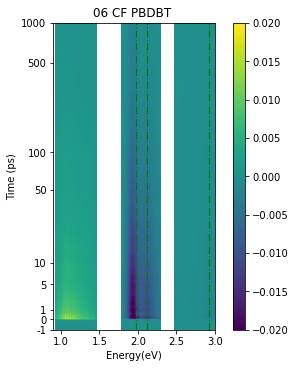

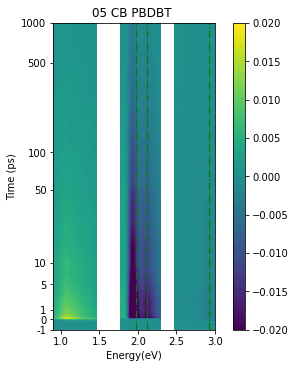

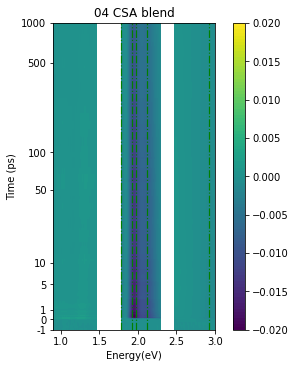

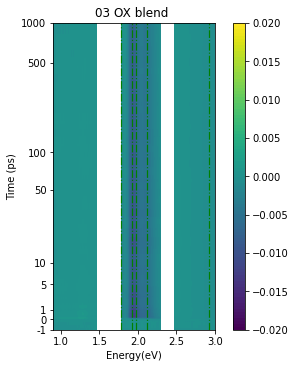

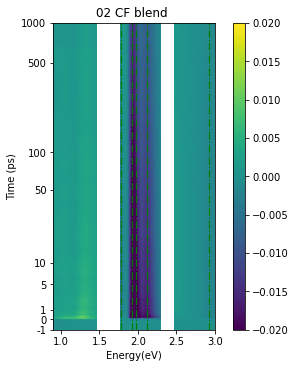

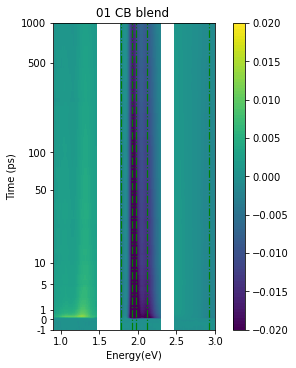

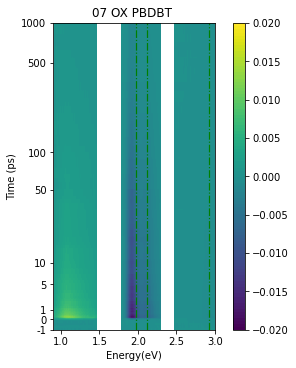

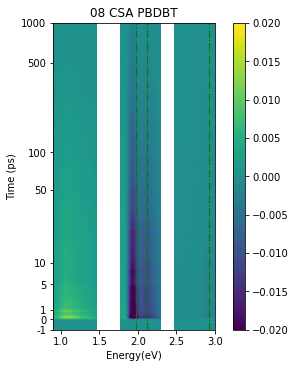

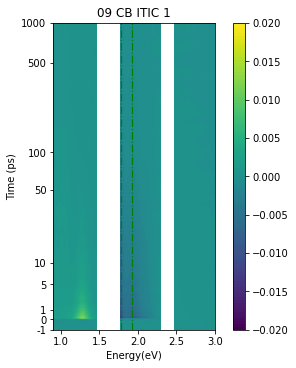

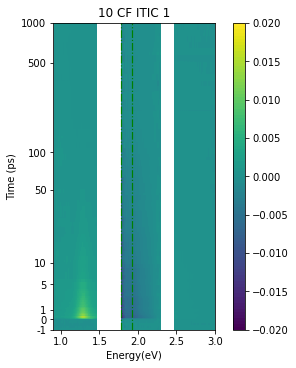

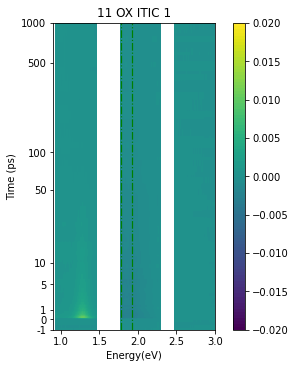

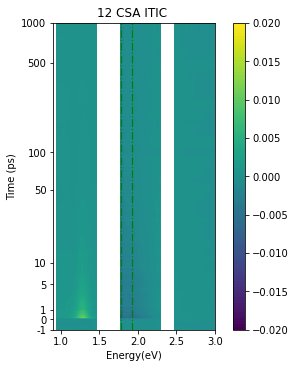

In [16]:
#method from mathplotlib documentation

viridis = cm.get_cmap('coolwarm', 100)
def plot_examples(colormaps, data, name):
    """
    Helper function to plot data with associated colormap.
    """
    n = len(colormaps)
    fig, axs = plt.subplots(1, n, figsize=(n * 2 + 2, 5),
                            constrained_layout=True, squeeze=False)
    for [ax, cmap] in zip(axs.flat, colormaps):
        psm = ax.pcolormesh(data.index,np.log10(data.columns+6), data.T, cmap=cmap, rasterized=True, vmin=-0.02, vmax=0.02)
        fig.colorbar(psm, ax=ax)
        ax.title.set_text(name)
    plt.xlim(0.9,3.0)
    yvals = np.asarray([-1, 0, 1, 5, 10, 50, 100, 500, 1000])
    ylogs = np.around(np.log10(yvals + 6), 2)
    plt.ylim(ylogs[0], ylogs[-1])
    plt.yticks(ylogs, labels=yvals)
    if "ITIC" in name:
      peaks = [1.78, 1.93]
    elif "PBDBT" in name:
      peaks = [1.97, 2.12, 2.92]
    elif 'blend' in name:
      peaks = [1.78, 1.93,1.97, 2.12, 2.92]
    else:
      peaks=[]
      
    for eg in peaks:
      plt.axvline(eg, ls='-.', lw=1.2, c='green')

    plt.xlabel('Energy(eV)')
    plt.ylabel('Time (ps)')
for name in merged_data:
  merged_data[name] = (merged_data[name].T).interpolate().T

  plot_examples([viridis], merged_data[name], name)
  plt.show()


Try adding again?

In [ ]:
#method from mathplotlib documentation

viridis = cm.get_cmap('coolwarm', 100)
def plot_comparison(colormaps, solvent):
    """
    Helper function to plot data with associated colormap.
    """
    n = len(colormaps)
    for name in merged_data:
      if solvent in name and 'ITIC' in name:
        d1 = merged_data[name]
      elif solvent in name and 'PBDBT' in name:
        d2 = merged_data[name]
      elif solvent in name and 'blend' in name:
        d3 = merged_data[name]
    data = 
    data = (d2+d1)
    fig, axs = plt.subplots(1, n, figsize=(n * 2 + 2, 3),
                            constrained_layout=True, squeeze=False)
    for [ax, cmap] in zip(axs.flat, colormaps):
        psm = ax.pcolormesh(data.index,np.log10(data.columns+6), data.T, cmap=cmap, rasterized=True, vmin=-0.01, vmax=0.01)
        fig.colorbar(psm, ax=ax)
        ax.title.set_text(name)
    plt.xlim(0.9,3.0)
    yvals = np.asarray([-5, -1, 0, 1, 5, 10, 50, 100, 500, 1000, 4000])
    ylogs = np.around(np.log10(yvals + 6), 2)
    plt.yticks(ylogs, labels=yvals)
    if "ITIC" in name:
      peaks = [1.78, 1.93]
    elif "PBDBT" in name:
      peaks = [1.97, 2.12, 2.92]
    elif 'blend' in name:
      peaks = [1.78, 1.93,1.97, 2.12, 2.92]
    else:
      peaks=[]
      
    for eg in peaks:
      plt.axvline(eg, ls='-.', lw=1.2, c='green')

    plt.xlabel('Energy(eV)')
    plt.ylabel('Time (ps)')
    plt.show()
plot_comparison([viridis], 'CB')


ValueError: ignored

Plotting 3d

In [ ]:
#code from https://blog.finxter.com/matplotlib-3d-plot-advanced/
#https://stackoverflow.com/questions/36589521/how-to-surface-plot-3d-plot-from-dataframe
for name in merged_data:
  fig = plt.figure(figsize=(10,10))
  ax = Axes3D(fig)
  # Create x and y 1D arrays
  a = np.asarray(merged_data[name].index)
  b = np.asarray(merged_data[name].columns)
  X,Y = np.meshgrid(a, b)
  # Create X and Y 2D arrays
  Z = merged_data[name].T
  # Plot using Axes notation
  surf = ax.plot_surface(X,Y,Z, rstride=1, cstride=1, cmap=cm.coolwarm,linewidth=1, antialiased=False)
  # Set axes lables
  ax.set(xlabel='Wavelength(nm)', ylabel='time (ps)', zlabel='dA')
  ax.view_init(elev=20, azim=100)
  ax.set_zlim(-.04, .01)
  ax.zaxis.set_major_locator(LinearLocator(10))
  ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

  fig.colorbar(surf, shrink=0.5, aspect=5)
  ax.title.set_text(name + ' Transient Spectroscopy')
  plt.show()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  del sys.path[0]


AttributeError: ignored

<Figure size 720x720 with 2 Axes>

AttributeError: ignored

<Figure size 720x720 with 2 Axes>

AttributeError: ignored

<Figure size 720x720 with 2 Axes>

AttributeError: ignored

<Figure size 720x720 with 2 Axes>

AttributeError: ignored

<Figure size 720x720 with 2 Axes>

AttributeError: ignored

<Figure size 720x720 with 2 Axes>

AttributeError: ignored

<Figure size 720x720 with 2 Axes>

AttributeError: ignored

<Figure size 720x720 with 2 Axes>

AttributeError: ignored

<Figure size 720x720 with 2 Axes>

AttributeError: ignored

<Figure size 720x720 with 2 Axes>

AttributeError: ignored

<Figure size 720x720 with 2 Axes>

AttributeError: ignored

<Figure size 720x720 with 2 Axes>

Kinetics?

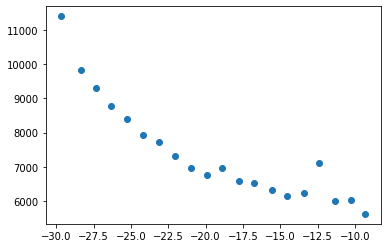

In [ ]:
#merge later, data analysis
name = "MAPI4"
a = []
xmax = []
for spec in sorted(Spec_data):
  if spec[:(len(name))] == name and spec[(len(name)+1):] < '11:38:00' and name == 'MAPI4':
    xmax.append(((Spec_data[spec]['Counts'].max())))
    a.append((pd.to_timedelta(str(Spec_data[spec].rec_time)) - pd.to_timedelta('0 days 11:46:13'))/timedelta(minutes = 1))

plt.scatter(np.asarray(a), (np.asarray(xmax)))



In [ ]:
laser_data = {}
for data in Spec_data:
  df = Spec_data[data][Spec_data[data]['Wavelength(nm)'].between(402,410)]
  df.title = data
  df.rec_time = Spec_data[data].rec_time
  df.int_time = Spec_data[data].int_time
  laser_data[data] = df



In [ ]:
def beam_fit(data):
  #from https://stackoverflow.com/questions/49370795/lorentzian-module
  #from https://millenia.cars.aps.anl.gov/software/python/lmfit/examples/example_use_pandas.html

  data.reset_index(level=0, inplace =True, drop=True)
  model = GaussianModel()
  params = model.guess(data['Counts'], x=data['Wavelength(nm)'])

  result = model.fit(data['Counts'], params, x=data['Wavelength(nm)'])

  result.plot_fit()

 

  data.center = float(result.fit_report()[result.fit_report().find('center:')+12:result.fit_report().find('center:')+18])
  data.sigma = float(result.fit_report()[result.fit_report().find('sigma:')+12:result.fit_report().find('sigma:')+18])
  data.amplitude = float(result.fit_report()[result.fit_report().find('amplitude:')+12:result.fit_report().find('amplitude:')+18])
  data.height = float(result.fit_report()[result.fit_report().find('height:')+12:result.fit_report().find('height:')+18])
  


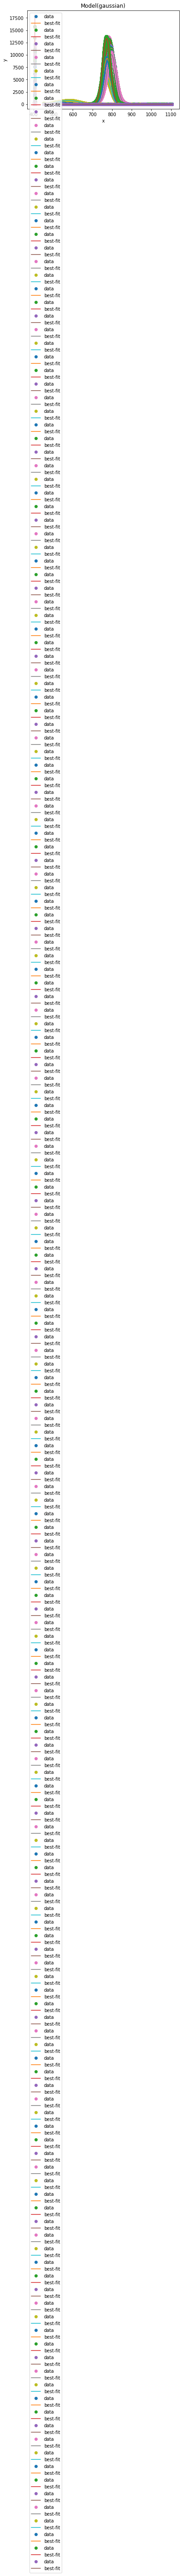

In [ ]:
for data in laser_data:
  beam_fit(laser_data[data])
for data in Spec_data:
  transdata = Spec_data[data][Spec_data[data]['Wavelength(nm)'] > 450]
  beam_fit(transdata)
  transdata.center = Spec_data[data].center
  transdata.sigma = Spec_data[data].sigma
  transdata.amplitude = Spec_data[data].amplitude
  transdata.height = Spec_data[data].height


In [ ]:
#time grouped data
spec_groups = {'MAPI4':[], 'TC6':[], 'p3htf8b2':[], 'roomlight':[], 'degraded':[], 'Subt53':[], 'p3htpcbm':[], 'MAPI4 short':[], 'TC2':[]}
for name in spec_groups:
  for spec in sorted(Spec_data):
    if spec[:(len(name))] == name and spec[(len(name)+1):] < '11:38:05' and name == 'MAPI4':
      spec_groups[name].append(spec)
    elif spec[:(len(name))] == name and name == 'MAPI4':
      spec_groups['MAPI4 short'].append(spec)
    elif spec[:(len(name))] == name and name != 'MAPI4':
      spec_groups[name].append(spec)
  

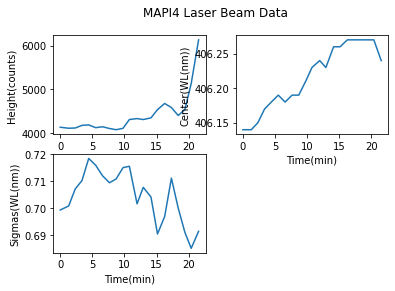

Wavelength Average: 406.21666666666664


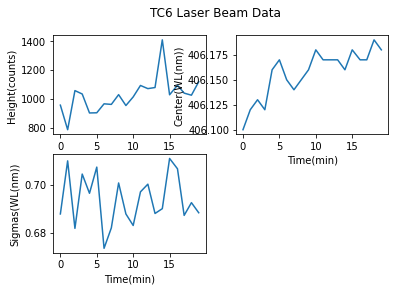

Wavelength Average: 406.157


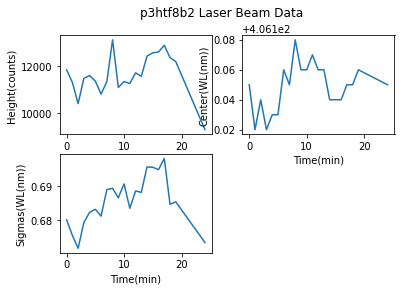

Wavelength Average: 406.1485714285714


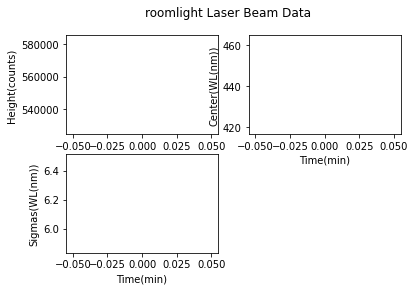

Wavelength Average: 440.72


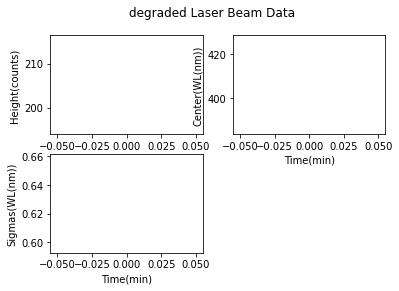

Wavelength Average: 406.15


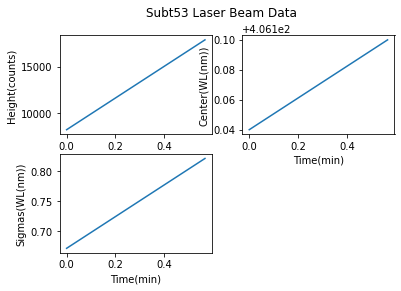

Wavelength Average: 406.16999999999996


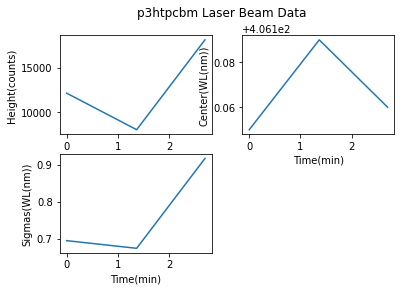

Wavelength Average: 406.1666666666667


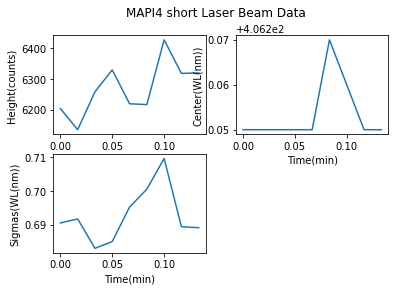

Wavelength Average: 406.25333333333333


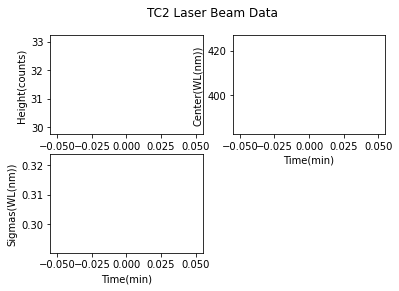

Wavelength Average: 404.58


In [ ]:
#Various transient bandwidth data

for name in spec_groups:
  heights = []
  centers = []
  sigmas = []
  times = []
  start_time = spec_groups[name][0].split()[1]
  for spec in spec_groups[name]:
    beam_fit(laser_data[spec])
    centers.append(laser_data[spec].center)
    heights.append(laser_data[spec].height)
    sigmas.append(laser_data[spec].sigma)
    times.append(float((pd.to_timedelta(str(Spec_data[spec].rec_time)) - pd.to_timedelta('0 days ' + start_time))/timedelta(minutes = 1)))
  plt.subplot(2,2,1)
  plt.plot(times, heights)
  plt.xlabel('Time(min)')
  plt.ylabel('Height(counts)')
  plt.subplot(2,2,2)
  plt.plot(times, centers)
  plt.xlabel('Time(min)')
  plt.ylabel('Center(WL(nm))')
  plt.subplot(2,2,3)
  plt.plot(times, sigmas)
  plt.xlabel('Time(min)')
  plt.ylabel('Sigmas(WL(nm))')
  plt.suptitle(name + " Laser Beam Data")
  plt.show()
  print('Wavelength Average: ' + str(statistics.mean(centers)))


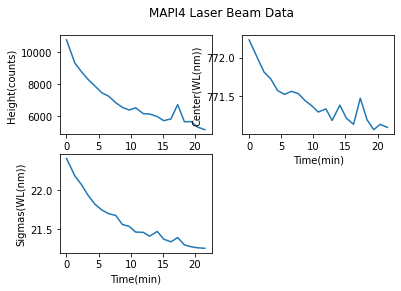

Wavelength Average: 771.4380952380952


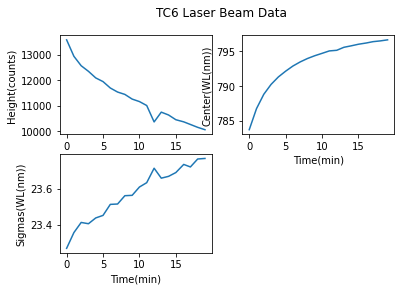

Wavelength Average: 793.261


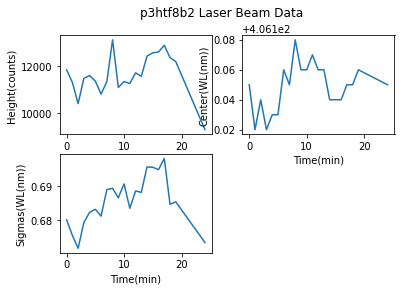

Wavelength Average: 406.1485714285714


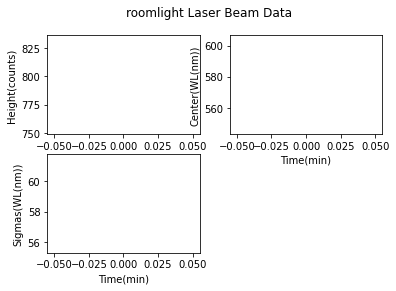

Wavelength Average: 574.91


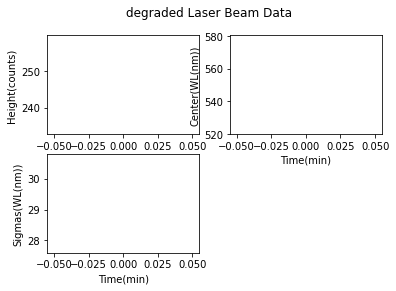

Wavelength Average: 550.11


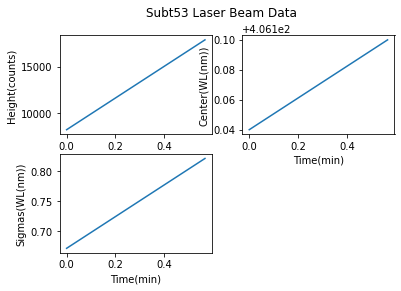

Wavelength Average: 406.16999999999996


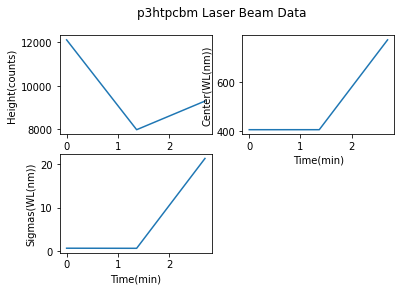

Wavelength Average: 529.0899999999999


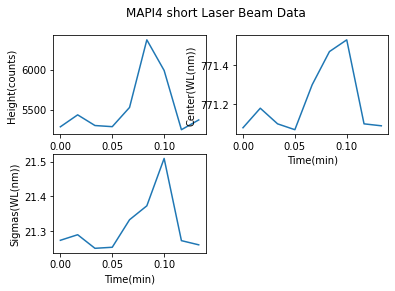

Wavelength Average: 771.2133333333334


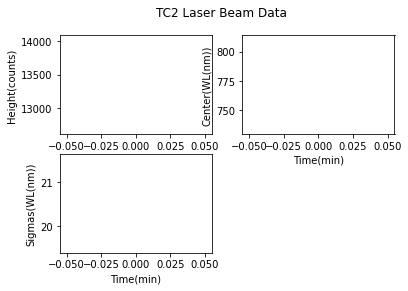

Wavelength Average: 771.66


In [ ]:
for name in spec_groups:
  heights = []
  centers = []
  sigmas = []
  times = []
  start_time = spec_groups[name][0].split()[1]
  for spec in spec_groups[name]:
    beam_fit(Spec_data[spec])
    centers.append(Spec_data[spec].center)
    heights.append(Spec_data[spec].height)
    sigmas.append(Spec_data[spec].sigma)
    times.append(float((pd.to_timedelta(str(Spec_data[spec].rec_time)) - pd.to_timedelta('0 days ' + start_time))/timedelta(minutes = 1)))
  plt.subplot(2,2,1)
  plt.plot(times, heights)
  plt.xlabel('Time(min)')
  plt.ylabel('Height(counts)')
  plt.subplot(2,2,2)
  plt.plot(times, centers)
  plt.xlabel('Time(min)')
  plt.ylabel('Center(WL(nm))')
  plt.subplot(2,2,3)
  plt.plot(times, sigmas)
  plt.xlabel('Time(min)')
  plt.ylabel('Sigmas(WL(nm))')
  plt.suptitle(name + " Laser Beam Data")
  plt.show()
  print('Wavelength Average: ' + str(statistics.mean(centers)))